In [96]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as rx
import rioxarray as rix
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard


<xarray.DataArray (band: 1, y: 120, x: 120)>
[14400 values with dtype=uint16]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 6.384e+05 6.384e+05 ... 6.396e+05 6.396e+05
  * y            (y) float64 6.995e+06 6.995e+06 ... 6.994e+06 6.994e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
EPSG:32635


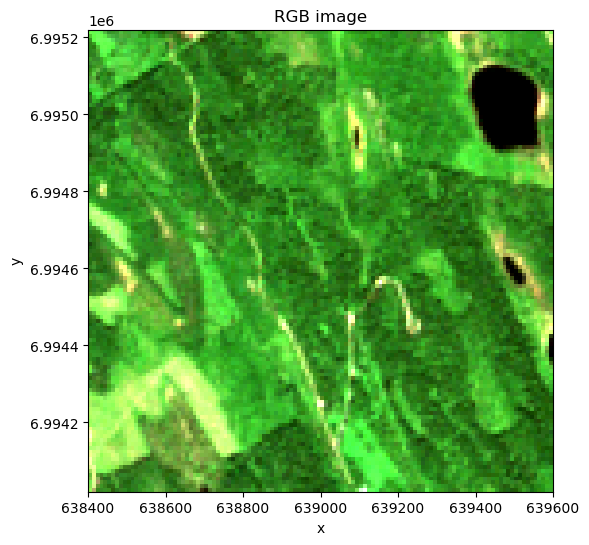

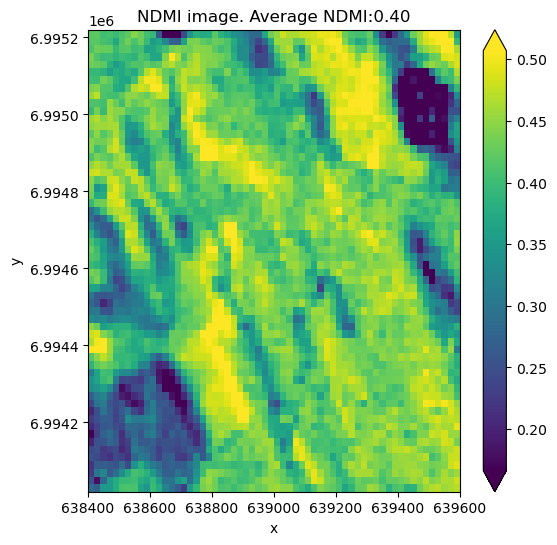

['S2A_MSIL2A_20170701T093031_25_48' 'S2A_MSIL2A_20170701T093031_16_58'
 'S2A_MSIL2A_20170701T093031_78_27' 'S2A_MSIL2A_20170701T093031_70_6'
 'S2A_MSIL2A_20170701T093031_19_10' 'S2A_MSIL2A_20170701T093031_43_68'
 'S2A_MSIL2A_20170701T093031_68_87' 'S2B_MSIL2A_20170801T095029_4_23'
 'S2A_MSIL2A_20170701T093031_70_78' 'S2B_MSIL2A_20170906T101019_56_80'
 'S2A_MSIL2A_20170701T093031_51_7' 'S2A_MSIL2A_20170613T101031_19_84'
 'S2A_MSIL2A_20170701T093031_39_73' 'S2A_MSIL2A_20170701T093031_58_44'
 'S2B_MSIL2A_20180201T093219_77_15' 'S2A_MSIL2A_20170701T093031_80_60'
 'S2A_MSIL2A_20170701T093031_47_58' 'S2A_MSIL2A_20170701T093031_32_4'
 'S2A_MSIL2A_20170701T093031_7_69' 'S2A_MSIL2A_20170701T093031_48_10']


In [129]:
# JUST FOR PLOTTING
def norm_diff(x,y):
    return (x-y)/(x+y)

child = "S2B_MSIL2A_20170801T095029_11_32"  # good example for faulty NDMI and pretty picture
child = "S2A_MSIL2A_20170701T093031_32_4"  # non faulty NDMI

def plot_folder(folder,rgb=True):
    parent = "data/"
    if rgb:
        plt.figure(figsize=(6, 6))
        blue = rix.open_rasterio(parent+f"{folder}/{folder}_B02.tif")
        print(blue)
        print(blue.rio.crs)
        green = rix.open_rasterio(parent+f"{folder}/{folder}_B03.tif")
        red = rix.open_rasterio(parent+f"{folder}/{folder}_B04.tif")
        rgb_img = rx.concat([red, green, blue], dim='band')
        # rgb_img = (red+green+blue).squeeze()
        rgb_img.plot.imshow(robust=True)
        plt.title("RGB image")
        plt.show()

    elif not rgb:
        plt.figure(figsize=(6, 6))
        nir = rix.open_rasterio(parent+f"{folder}/{folder}_B8A.tif")
        swir = rix.open_rasterio(parent+f"{folder}/{folder}_B11.tif")
        nir = nir.astype('float32')
        swir = swir.astype('float32')
        
        avg_ndmi = np.mean(norm_diff(nir.values,swir.values).squeeze())
        ndmi_img = norm_diff(nir,swir).squeeze()

        ndmi_img.plot.imshow(robust=True,cmap='viridis')
        plt.title(f"NDMI image. Average NDMI:{avg_ndmi:.2f}")
        plt.show()

plot_folder(child,rgb=True)
plot_folder(child,rgb=False)

In [132]:
def convert_to_geo_coords(x, y, transform):
    lon = transform[2] + x * transform[0] + y * transform[1]
    lat = transform[5] + x * transform[4] + y * transform[3]
    return lon, lat

child = "S2A_MSIL2A_20170701T093031_32_4"  # non faulty NDMI
blue = rix.open_rasterio(f"data/{child}/{child}_B02.tif")
x_image, y_image = 6.384e+05, 6.995e+06  # Replace with actual image coordinates
transform = blue.rio.transform()
vectorized_convert = np.vectorize(convert_to_geo_coords, excluded=['transform'])

# Apply the vectorized function to image coordinates
geo_coordinates = vectorized_convert(x_image, y_image, transform=transform)

print("Geographic Coordinates:", geo_coordinates)
#  need to find out how to show the location of our satellite image

Geographic Coordinates: (array(7022400.), array(611220.))


In [98]:
import os

def list_folders(directory):
    folders = np.array([d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))])
    return folders
all_folders = list_folders("data/")
print(all_folders)
print(len(all_folders))


['S2A_MSIL2A_20170701T093031_25_48' 'S2A_MSIL2A_20170701T093031_16_58'
 'S2A_MSIL2A_20170701T093031_78_27' ... 'S2B_MSIL2A_20170801T095029_11_32'
 'S2B_MSIL2A_20170906T101020_78_48' 'S2B_MSIL2A_20170802T092029_10_37']
7343


In [99]:

# Read GeoTIFF file
def norm_diff(x,y):
    try:
        return (x-y)/(x+y)
    except Exception as e:
        print(e)
        return None

# testchild = "S2A_MSIL2A_20171101T094131_1_38"


def get_input_label(folder):
    try:
        base_path=f"data/{folder}/{folder}"

        blue = rix.open_rasterio(f"{base_path}_B02.tif")
        green = rix.open_rasterio(f"{base_path}_B03.tif")
        red = rix.open_rasterio(f"{base_path}_B04.tif")     

        rgb = np.concatenate([red.values,green.values,blue.values], axis=0)

        # print(rgb)
        nir = rix.open_rasterio(f"{base_path}_B8A.tif")
        swir = rix.open_rasterio(f"{base_path}_B11.tif")
        nir = nir.astype('float32')
        swir = swir.astype('float32')

        ndmi = norm_diff(nir.values.squeeze(),swir.values.squeeze())
        label = np.mean(ndmi)
        
        return rgb, label
    except Exception as e:
        print(e)
        return None, None

In [100]:
folders = all_folders.copy()

input = np.zeros((len(folders), 3, 120, 120))
labels = np.zeros((len(folders), 1))

for j, folder in enumerate(folders):
    rgb, label = get_input_label(folder)
    # print(label)
    input[j] = rgb
    labels[j] = label

data/S2B_MSIL2A_20170802T092029_18_24/S2B_MSIL2A_20170802T092029_18_24_B03.tif: No such file or directory


/var/folders/68/x8klff196fl8_dk1n2t0qbtc0000gn/T/ipykernel_11110/403061018.py:4: RuntimeWarning: invalid value encountered in divide
  return (x-y)/(x+y)


data/S2A_MSIL2A_20170613T101031_24_59/S2A_MSIL2A_20170613T101031_24_59_B02.tif: No such file or directory


/var/folders/68/x8klff196fl8_dk1n2t0qbtc0000gn/T/ipykernel_11110/403061018.py:4: RuntimeWarning: invalid value encountered in divide
  return (x-y)/(x+y)
/var/folders/68/x8klff196fl8_dk1n2t0qbtc0000gn/T/ipykernel_11110/403061018.py:4: RuntimeWarning: invalid value encountered in divide
  return (x-y)/(x+y)
/var/folders/68/x8klff196fl8_dk1n2t0qbtc0000gn/T/ipykernel_11110/403061018.py:4: RuntimeWarning: invalid value encountered in divide
  return (x-y)/(x+y)


data/S2A_MSIL2A_20170701T093031_86_9/S2A_MSIL2A_20170701T093031_86_9_B03.tif: No such file or directory


In [101]:
# remove rows from label and input where label is nan or invalid (>1 or <-1)
faulty_row = (np.isnan(labels) | (np.abs(labels)>1)).squeeze()
print(folders.shape)
labels_clean = labels[~faulty_row]
input_clean = input[~faulty_row]
folders_clean = folders[~faulty_row]
# labels = np.clip(labels, -1, 1)
print(len(labels))
print(len(labels_clean))
print(len(input_clean))
# print(input[:3])
# print(labels[:3])
# print(input.shape)
# np.save("arrays/clean_folders.npy", folders_clean,)
# np.save("arrays/clean_labels.npy", labels_clean)
# np.save("arrays/clean_input.npy", input_clean)

(7343,)
7343
7336
7336


In [102]:

# Convert labels to categorical
labels_categorical = tf.keras.utils.to_categorical(labels_clean, num_classes=10)

# Print the shape of the categorical labels
print(labels_categorical.shape)


(7336, 10)


In [103]:
# start constructing network for RGB dimension (120,120,3)
input_clean = input_clean.reshape(len(input_clean),120,120,3)
input_shape = input_clean.shape

# Example parameters, replace with your actual values
# img_placeholder = tf.placeholder(tf.float32, input_shape)
num_classes = 10  # Replace with your actual number of classes
is_training = True  # Set to False for inference
prediction_threshold = 0.5  # Set the threshold based on your needs

# pre-trained network: pt
input_t = tf.keras.Input(shape=(120,120,3))
model_res = tf.keras.applications.resnet50.ResNet50(
    include_top=False,
    weights='imagenet',
    input_tensor=input_t,
    input_shape=(120,120,3),
    pooling=None,
    classes=10,
)

# pretrained model
model = tf.keras.Sequential()
# model.add(tf.keras.layers.Lambda(lambda image: tf.image.resize(image, (224, 224))))
model.add(model_res)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.BatchNormalization())
# I would not put a too complicated network on top to prevent overfitting
# model.add(tf.keras.layers.Dense(256, activation="relu"))
# model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(128, activation="relu"))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(64, activation="relu"))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(10, activation="softmax"))


In [104]:
log_dir = "logs/pt_fit/"  # Choose a suitable directory
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
# callback = tf.keras.callbacks.ModelCheckpoint(filepath='beNet50.h5', monitor='acc', mode="max", save_best_only=True)
checkpoint_path = "weights/pt_weights.best.h5"
# default metric to compare whether it's "best" is loss
model_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_best_only=True, save_weights_only=True)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(input_clean, labels_categorical, epochs=1, batch_size=32, verbose=1, validation_split=0.2, callbacks=[tensorboard_callback,model_callback])

KeyboardInterrupt: 

In [ ]:
# Example parameters, replace with your actual values
# img_placeholder = tf.placeholder(tf.float32, input_shape)
num_classes = 10  # Replace with your actual number of classes
is_training = True  # Set to False for inference
prediction_threshold = 0.5  # Set the threshold based on your needs

# same structure network but not pre-trained (initialised): init
input_t = tf.keras.Input(shape=(120,120,3))
model_res = tf.keras.applications.resnet50.ResNet50(
    include_top=False,
    weights=None,
    input_tensor=input_t,
    input_shape=(120,120,3),
    pooling=None,
    classes=10,
)

# pretrained model
model = tf.keras.Sequential()
# model.add(tf.keras.layers.Lambda(lambda image: tf.image.resize(image, (224, 224))))
model.add(model_res)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(256, activation="relu"))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(128, activation="relu"))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(64, activation="relu"))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(10, activation="softmax"))
# model.summary()

In [ ]:
log_dir = "logs/init_fit/"  # Choose a suitable directory
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
# callback = tf.keras.callbacks.ModelCheckpoint(filepath='beNet50.h5', monitor='acc', mode="max", save_best_only=True)
checkpoint_path = "weights/init_weights.best.h5"
# default metric to compare whether it's "best" is loss
model_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_best_only=True, save_weights_only=True)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(input_clean, labels_categorical, epochs=10, batch_size=32, verbose=1, validation_split=0.2, callbacks=[tensorboard_callback,model_callback])

Epoch 1/10
72/72 [==============================] - 582s 8s/step - loss: 2.4358 - accuracy: 0.2309 - val_loss: 9.1046 - val_accuracy: 0.9168
Epoch 2/10
72/72 [==============================] - 479s 7s/step - loss: 1.3257 - accuracy: 0.6719 - val_loss: 0.7646 - val_accuracy: 1.0000
Epoch 3/10
72/72 [==============================] - 481s 7s/step - loss: 0.5060 - accuracy: 0.9293 - val_loss: 0.1598 - val_accuracy: 1.0000
Epoch 4/10
72/72 [==============================] - 482s 7s/step - loss: 0.1990 - accuracy: 0.9792 - val_loss: 0.0669 - val_accuracy: 1.0000
Epoch 5/10
72/72 [==============================] - 494s 7s/step - loss: 0.0852 - accuracy: 0.9952 - val_loss: 0.0278 - val_accuracy: 1.0000
Epoch 6/10
12/72 [====>.........................] - ETA: 6:35 - loss: 0.0510 - accuracy: 1.0000

KeyboardInterrupt: 

In [106]:
# Example parameters, replace with your actual values
# img_placeholder = tf.placeholder(tf.float32, input_shape)
num_classes = 10  # Replace with your actual number of classes
is_training = False  # Set to False for inference
prediction_threshold = 0.5  # Set the threshold based on your needs

# pre-trained network with frozen ResNet weights (freeze): fr
input_t = tf.keras.Input(shape=(120,120,3))
model_res = tf.keras.applications.resnet50.ResNet50(
    include_top=False,
    weights='imagenet',
    input_tensor=input_t,
    input_shape=(120,120,3),
    pooling=None,
    classes=10,
)
# optional for not training the whole model
for layer in model_res.layers:
    layer.trainable = False

# pretrained model
model = tf.keras.Sequential()
# model.add(tf.keras.layers.Lambda(lambda image: tf.image.resize(image, (224, 224))))
model.add(model_res)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.Dense(256, activation="relu"))
# model.add(tf.keras.layers.Dropout(0.5))
# model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.Dense(128, activation="relu"))
# model.add(tf.keras.layers.Dropout(0.5))
# model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(64, activation="relu"))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(10, activation="softmax"))
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten_12 (Flatten)        (None, 32768)             0         
                                                                 
 batch_normalization_43 (Ba  (None, 32768)             131072    
 tchNormalization)                                               
                                                                 
 dense_42 (Dense)            (None, 64)                2097216   
                                                                 
 dropout_30 (Dropout)        (None, 64)                0         
                                                                 
 batch_normalization_44 (Ba  (None, 64)                256       
 tchNormalization)                                   

In [107]:
log_dir = "logs/fr_fit/"  # Choose a suitable directory
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
# callback = tf.keras.callbacks.ModelCheckpoint(filepath='beNet50.h5', monitor='acc', mode="max", save_best_only=True)
checkpoint_path = "weights/fr_weights.best.h5"
# default metric to compare whether it's "best" is loss
model_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_best_only=True, save_weights_only=True)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(input_clean, labels_categorical, epochs=10, batch_size=32, verbose=1, validation_split=0.2, callbacks=[tensorboard_callback,model_callback])

Epoch 1/10
184/184 [==============================] - 304s 2s/step - loss: 1.5670 - accuracy: 0.5673 - val_loss: 0.1963 - val_accuracy: 1.0000
Epoch 2/10
184/184 [==============================] - 279s 2s/step - loss: 0.1517 - accuracy: 0.9881 - val_loss: 0.0231 - val_accuracy: 1.0000
Epoch 3/10
184/184 [==============================] - 279s 2s/step - loss: 0.0323 - accuracy: 0.9983 - val_loss: 0.0062 - val_accuracy: 1.0000
Epoch 4/10
184/184 [==============================] - 277s 2s/step - loss: 0.0144 - accuracy: 0.9990 - val_loss: 0.0035 - val_accuracy: 1.0000
Epoch 5/10
184/184 [==============================] - 276s 2s/step - loss: 0.0078 - accuracy: 0.9998 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 6/10
184/184 [==============================] - 276s 2s/step - loss: 0.0053 - accuracy: 0.9995 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 7/10
184/184 [==============================] - 277s 2s/step - loss: 0.0033 - accuracy: 0.9998 - val_loss: 8.7486e-04 - val_accuracy: 1.